# Vienna data cube
TODO Link to metadata (source data, a/p metadata)

## Connect to s3 bucket

In [1]:
import s3fs
import xarray as xr
import rioxarray as rxr
from configparser import ConfigParser
import os
def config(filename, section='s3'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)
    # get section, default to postgresql
    s3 = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            s3[param[0]] = param[1]
    else:
        raise KeyError(
            f'Section {section} not found in {filename}. Did you specifiy the right path?')
    return s3

try:
    s3_config = config('../../database.ini')
except KeyError as er:
    print(er)
    print('Config file not found or malformed, trying with environment variables...')
    if (os.environ.get('S3_FAIRICUBE_STORAGE_BUCKET') is None):
        print('environment variables not set, contact the admin')
    else:
        s3_config = {
            's3_fairicube_storage_bucket': os.environ.get('S3_FAIRICUBE_STORAGE_BUCKET'),
            's3_fairicube_storage_key': os.environ.get('S3_FAIRICUBE_STORAGE_KEY'),
            's3_fairicube_storage_secret': os.environ.get('S3_FAIRICUBE_STORAGE_SECRET')}


In [8]:
s3fs_FS = s3fs.S3FileSystem(
    key=s3_config['s3_fairicube_storage_key'],
    secret=s3_config['s3_fairicube_storage_secret'],
)

## List cube dimensions

In [14]:
# TODO replace with STAC API code, once the data is registered to the FAIRiCUBE STAC Catalog
# List all files in the folder
files = s3fs_FS.ls('s3:///fairicube/vienna_data/100m/r02_dem')

# Print the list of files
for file in files:
    print(file)

fairicube/vienna_data/100m/r02_dem/
fairicube/vienna_data/100m/r02_dem/r02_dem_mean_100m_b1_1_1.tif


## Load dimensions
### Spatiotemporal cube

In [33]:
# TODO replace with STAC API code, once the data is registered to the FAIRiCUBE STAC Catalog
# spatiotemporal cube - max daily 2m temperature
s3map = s3fs.S3Map(root='s3:///fairicube/vienna_data/100m/TN_2020-01-01_2024-05-01_epsg31256_100m_regridded.zarr', s3=s3fs_FS)
ds = xr.open_zarr(store=s3map)

### Thematic spatial cube

In [102]:
# land use
import pandas as pd
da = rxr.open_rasterio(s3fs_FS.open('s3://fairicube/vienna_data/100m/r01_landuse/r01_real_land_use2020_100m_b32_1_1.tif'))
# convert bands into data variables
ds_landuse = xr.merge([da[band].to_dataset(name=f'land_use{band+1}') for band in range(0,32)], compat='override')
ds_landuse

<xarray.Dataset>
Dimensions:      (x: 300, y: 230)
Coordinates:
    band         int32 1
  * x            (x) float64 -1.115e+04 -1.105e+04 ... 1.865e+04 1.875e+04
  * y            (y) float64 3.54e+05 3.538e+05 3.538e+05 ... 3.312e+05 3.31e+05
    spatial_ref  int32 0
Data variables: (12/32)
    land_use1    (y, x) float32 ...
    land_use2    (y, x) float32 ...
    land_use3    (y, x) float32 ...
    land_use4    (y, x) float32 ...
    land_use5    (y, x) float32 ...
    land_use6    (y, x) float32 ...
    ...           ...
    land_use27   (y, x) float32 ...
    land_use28   (y, x) float32 ...
    land_use29   (y, x) float32 ...
    land_use30   (y, x) float32 ...
    land_use31   (y, x) float32 ...
    land_use32   (y, x) float32 ...

In [103]:
# digital elevation model
da = rxr.open_rasterio(s3fs_FS.open('s3://fairicube/vienna_data/100m/r02_dem/r02_dem_mean_100m_b1_1_1.tif'))
ds_dem = da.drop_vars('band').squeeze().to_dataset(name='dem')
ds_dem

In [105]:
# merge into one cube
cube = xr.merge([ds_landuse, ds_dem])
cube

<xarray.Dataset>
Dimensions:      (x: 300, y: 230)
Coordinates:
    band         int32 1
  * x            (x) float64 -1.115e+04 -1.105e+04 ... 1.865e+04 1.875e+04
  * y            (y) float64 3.54e+05 3.538e+05 3.538e+05 ... 3.312e+05 3.31e+05
    spatial_ref  int32 0
Data variables: (12/33)
    land_use1    (y, x) float32 ...
    land_use2    (y, x) float32 ...
    land_use3    (y, x) float32 ...
    land_use4    (y, x) float32 ...
    land_use5    (y, x) float32 ...
    land_use6    (y, x) float32 ...
    ...           ...
    land_use28   (y, x) float32 ...
    land_use29   (y, x) float32 ...
    land_use30   (y, x) float32 ...
    land_use31   (y, x) float32 ...
    land_use32   (y, x) float32 ...
    dem          (y, x) float32 ...

## Explore the cube
### Spatiotemporal cube

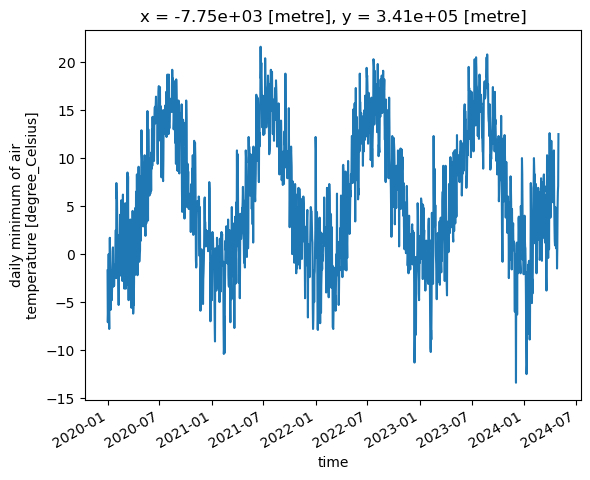

In [34]:
# spatiotemporal cube (2m max temperature)
# time series of one location
ds.TN.sel(x=-7700, y=341000, method='ffill').plot()

### Thematic spatial cube

In [112]:
# get all values from a list of locations, and convert to dataframe
cube.sel(x=-7700, y=341000, method='ffill').expand_dims('band').to_dataframe()

,x,y,spatial_ref,land_use1,land_use2,land_use3,land_use4,land_use5,land_use6,land_use7,...,land_use24,land_use25,land_use26,land_use27,land_use28,land_use29,land_use30,land_use31,land_use32,dem
band,,,,,,,,,,,,,,,,,,,,,
1,-7750.0,341050.0,0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,225.316086


In [ ]:
# TODO get values in a neighborhood (window) of a given location